In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

TICKER = "HG=F"        # Copper futures
START  = "2005-01-01"
END    = None
FREQ   = "M"           # 'D','W','M'
FORECAST_STEPS = 12
CSV_PATH = "series_yahoo.csv"

P = Q = range(0, 3)
SP = SQ = range(0, 3)
SEASONAL_PERIOD = 12

FIGDIR = Path(".")


In [2]:
def save_and_show(name, figsize=(10, 4)):
    out = FIGDIR / f"{name}.png"
    plt.tight_layout()
    plt.savefig(out, dpi=140, bbox_inches="tight")
   # print(f"[saved] {out.resolve()}")
    plt.show()


In [3]:
def _to_close(df, ticker):
    if "Close" in df.columns and not isinstance(df.columns, pd.MultiIndex):
        return df["Close"].dropna()

    if isinstance(df.columns, pd.MultiIndex):
        if "Close" in df.columns.get_level_values(0):
            block = df["Close"]
            if ticker in block.columns:
                return block[ticker].dropna()
            return block.iloc[:, 0].dropna()

    if "Adj Close" in df.columns:
        ser = df["Adj Close"]
        return (ser if isinstance(ser, pd.Series) else ser.iloc[:, 0]).dropna()

    raise ValueError("No closing price found.")

def download_series(ticker, start, end, freq):
    import yfinance as yf
    df = yf.download(ticker, start=start, end=end, progress=False)
    ser = _to_close(df, ticker)
    ser.name = "Price"

    if freq == "D":
        return ser.asfreq("B").ffill()
    if freq == "W":
        return ser.resample("W-FRI").last()
    if freq == "M":
        return ser.resample("M").last()
    raise ValueError("freq must be D/W/M")

def write_read_csv(series, path, freq):
    series.to_frame().to_csv(path, index_label="Date")
    back = pd.read_csv(path, parse_dates=["Date"], index_col="Date")["Price"]

    if freq == "D":
        return back.asfreq("B").ffill()
    if freq == "W":
        return back.asfreq("W-FRI")
    if freq == "M":
        return back.asfreq("M")
    return back


In [4]:
def adf_check(x):
    res = adfuller(x.dropna(), autolag="AIC")
    return res[0], res[1]

def choose_transform(y, s):
    candidates = [
        (y, (0, 0), "Level"),
        (y.diff(), (1, 0), "Diff1"),
        (y.diff(s), (0, 1), f"Seasonal{s}"),
        (y.diff().diff(s), (1, 1), f"Diff1+Seasonal{s}")
    ]

    for ser, (d, D), lab in candidates:
        stat, p = adf_check(ser)
        print(f"{lab:18} ADF={stat:+.3f} p={p:.4f}")
        if p < 0.05:
            print(f"Chosen: {lab} -> (d={d},D={D})")
            return ser.dropna(), (d, D), lab

    return y.diff().diff(s).dropna(), (1, 1), f"Diff1+Seasonal{s}"

def plot_series(y, title, fname):
    y.plot(figsize=(8, 3), title=title)
    plt.xlabel("Date"); plt.ylabel("Price")
    save_and_show(fname)

def plot_acf_pacf(y, stationary, lags=36):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plot_acf(y.dropna(), lags=lags, ax=axes[0])
    axes[0].set_title("ACF (raw series)")
    plot_acf(stationary, lags=lags, ax=axes[1])
    axes[1].set_title("ACF (stationary series)")
    save_and_show("fig_acf_compare")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plot_pacf(y.dropna(), lags=lags, method="ywm", ax=axes[0])
    axes[0].set_title("PACF (raw series)")
    plot_pacf(stationary, lags=lags, method="ywm", ax=axes[1])
    axes[1].set_title("PACF (stationary series)")
    save_and_show("fig_pacf_compare")


In [5]:
def grid_search(y, d, D, s, pgrid, qgrid, Pgrid, Qgrid):
    best, best_aic = None, np.inf
    for p in pgrid:
        for q in qgrid:
         for P in Pgrid:
            for Q in Qgrid:
                    try:
                        fit = SARIMAX(
                            y, order=(p, d, q), seasonal_order=(P, D, Q, s),
                            enforce_stationarity=False, enforce_invertibility=False
                        ).fit(disp=False)
                        if fit.aic < best_aic:
                            best_aic = fit.aic
                            best = (p, d, q, P, D, Q, s)
                    except:
                        pass
    print("Best order:", best, "AIC=", best_aic)
    return best

def ljung_box(resid):
    print(acorr_ljungbox(resid.dropna(), lags=[12, 24], return_df=True))


In [6]:
def rolling_backtest(y, order, sorder, start_frac=0.7):
    start = int(len(y) * start_frac)
    preds, naive, seas, act = [], [], [], []

    for t in range(start, len(y)):
        train, true = y.iloc[:t], y.iloc[t]
        try:
            f = SARIMAX(train, order=order, seasonal_order=sorder,
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            p = f.forecast(1).iloc[0]
        except:
            p = train.iloc[-1]

        preds.append(p)
        naive.append(train.iloc[-1])
        seas.append(train.iloc[-SEASONAL_PERIOD] if len(train) > SEASONAL_PERIOD else train.iloc[-1])
        act.append(true)

    act, preds, naive, seas = map(np.array, [act, preds, naive, seas])

    mae = lambda a, b: np.mean(np.abs(a - b))
    rmse = lambda a, b: np.sqrt(np.mean((a - b) ** 2))
    mape = lambda a, b: np.mean(np.abs((a - b) / a)) * 100

    print({
        "model": (mae(act, preds), rmse(act, preds), mape(act, preds)),
        "naive": (mae(act, naive), rmse(act, naive), mape(act, naive)),
        "snaive": (mae(act, seas), rmse(act, seas), mape(act, seas))
    })


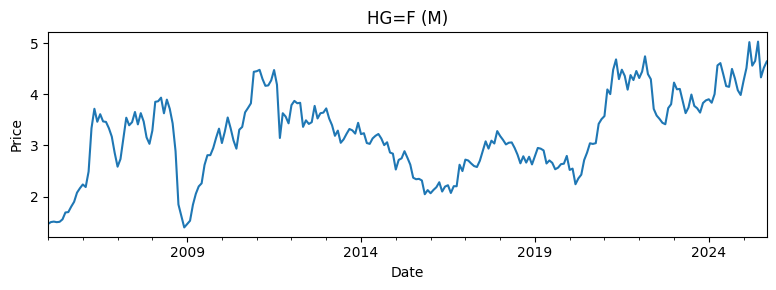

In [7]:
print("Downloading data...")
y_raw = download_series(TICKER, START, END, FREQ)
y = write_read_csv(y_raw, CSV_PATH, FREQ)

plot_series(y, f"{TICKER} ({FREQ})", "fig_history")

Level              ADF=-2.532 p=0.1079
Diff1              ADF=-7.058 p=0.0000
Chosen: Diff1 -> (d=1,D=0)


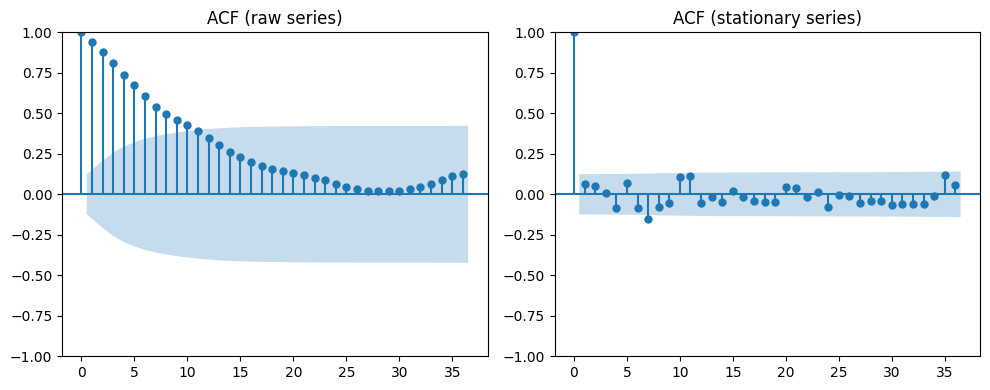

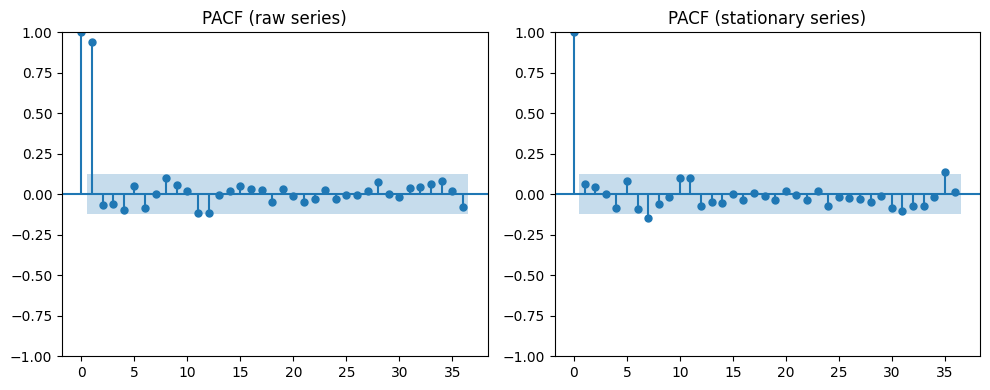

/home/kamal12054/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kamal12054/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kamal12054/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kamal12054/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kamal12054/.local/lib/python3.10/site-packages/statsmo

Best order: (0, 1, 1, 1, 0, 2, 12) AIC= -14.038340211743282
                                        SARIMAX Results                                        
Dep. Variable:                                   Price   No. Observations:                  249
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                  12.019
Date:                                 Tue, 02 Sep 2025   AIC                            -14.038
Time:                                         22:43:50   BIC                              2.975
Sample:                                     01-31-2005   HQIC                            -7.169
                                          - 09-30-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         

In [8]:
stationary, (d, D), lab = choose_transform(y, SEASONAL_PERIOD)

# Raw and stationary plots side-by-side
plot_acf_pacf(y, stationary, lags=36)

best = grid_search(y, d, D, SEASONAL_PERIOD, P, Q, SP, SQ)
order = (best[0], best[1], best[2])
sorder = (best[3], best[4], best[5], best[6])

fit = SARIMAX(y, order=order, seasonal_order=sorder,
              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

print(fit.summary())
ljung_box(fit.resid)

/home/kamal12054/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'model': (0.19477309824554354, 0.2503704431427081, 5.02689000512782), 'naive': (0.19531999270121259, 0.24878970760508232, 5.020686405251243), 'snaive': (0.5783400154113769, 0.7582555373314912, 14.810301541896528)}


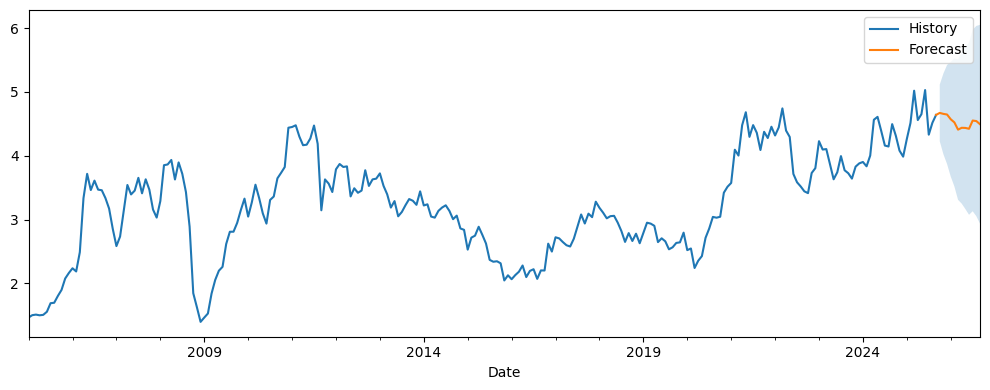

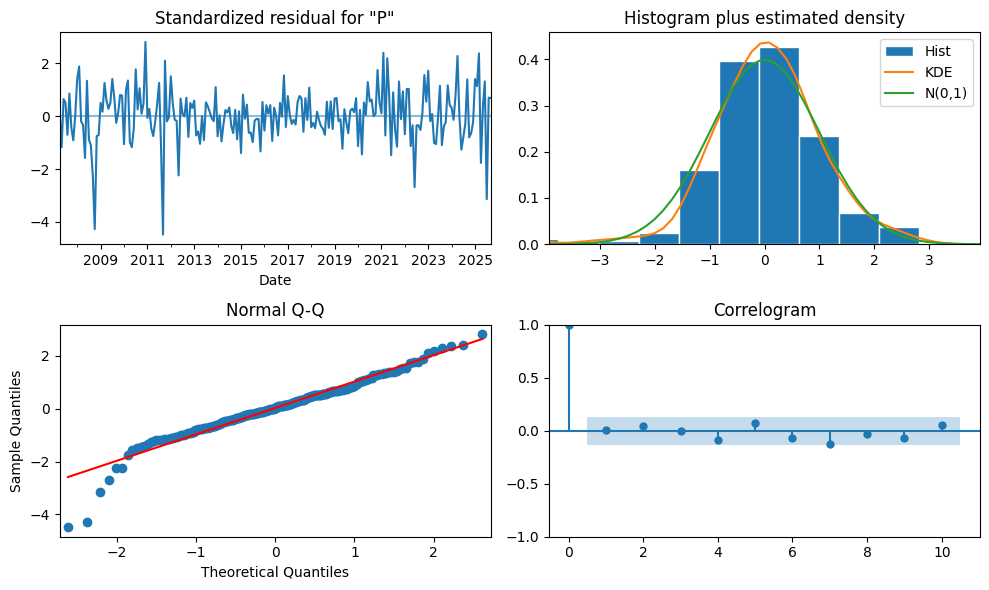

In [9]:
rolling_backtest(y, order, sorder)

fcst = fit.get_forecast(steps=FORECAST_STEPS)
mean, ci = fcst.predicted_mean, fcst.conf_int()
last = pd.Series([y.iloc[-1]], index=[y.index[-1]])
line = pd.concat([last, mean])

plt.figure(figsize=(10, 4))
y.plot(label="History")
line.plot(label="Forecast")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.2)
plt.legend()
save_and_show("fig_forecast")

fit.plot_diagnostics(figsize=(10, 6))
save_and_show("fig_diagnostics")